<h1>Modelos de regresión generalizados - Práctica: Predicción de morosidad + inferencia de rechazados </h1>

`Autor: Manuela Larrea Gómez`

<hr>

# 💼 Descripción del problema



<p><img style="float:right; margin:20px; padding:20px; max-height:250px" src=https://as2.ftcdn.net/v2/jpg/02/74/61/15/1000_F_274611589_IvowcPBn2jfNgxzdl7n6BRyKpbJq3BMB.jpg></p>
<p style="text-align:justify;">
Las instituciones bancarias tienen un conjunto de pautas mediante las cuales deciden si ofrecen o no préstamos personales a los potenciales consumidores que los buscan. Como resultado, la información incluida en sus sistemas no siempre es completa.

Como resultado, los modelos que ayudan al banco a descubrir tendencias morosas son de naturaleza semisupervisada.
</p>

## Objetivo

Ajustar un modelo que **prediga** la probabilidad de ser **moroso** de un cliente que solicita un crédito


## Modelo planteado para la resolución del problema:

Dada la naturaleza binaria de la variable de respuesta (morosidad), la **regresión logística** es una opción natural y efectiva para modelar y predecir el riesgo de morosidad en el contexto de la concesión de préstamos personales. Específicamente, se plantea el uso de un modelo de regresión logística binaria.

### Supuestos de Regresión Logística

El modelo de regresión logística requiere varios supuestos clave. Estos son los siguientes: -

1. El modelo de regresión logística requiere que la variable dependiente sea de naturaleza binaria, multinomial u ordinal.

2. Requiere que las observaciones sean independientes entre sí. Por tanto, las observaciones no deberían provenir de mediciones repetidas.

3. El algoritmo de regresión logística requiere poca o ninguna multicolinealidad entre las variables independientes. Significa que las variables independientes no deben estar demasiado correlacionadas entre sí.

4. El modelo de regresión logística supone linealidad de variables independientes y probabilidades logarítmicas.

5. El éxito del modelo de regresión logística depende del tamaño de la muestra. Normalmente, se requiere un tamaño de muestra grande para lograr una alta precisión.

Por lo tanto, es necesario garantizar que los datos cumplen estos supuestos

## Descripción del **dataset**

-   ACEPTADOS_TRAIN/TEST.- contiene las solicitudes de crédito que han sido aceptadas y para las cuales se conoce si el cliente terminó devolviéndolo (0) o no (1, fue moroso). Para dichas solicitudes se dispone del valor de las variables explicativas en el momento de hacer la solicitud. En ambas tablas se ha hecho un balanceo de clases 50-50 (la tasa real es del 5%).

-   RECHAZADOS.- contiene las solicitudes de crédito que fueron rechazadas y para las cuales no se conoce por tanto si el cliente fue o no moroso. Para dichas solicitudes solo se dispone del valor de las variables explicativas en el momento de hacer la solicitud.

Cada dataset tiene los siguientes variables:

-   AGE: Edad

-   BUREAU: Clase de riesgo de la Oficina de crédito

-   CAR: Tipo de vehículo

-   CARDS: Tipo de tarjeta de crédito (Visa, MasterCard, ...)

-   CASH: Dinero en efectivo solicitado

-   CHILDREN: Número de niños

-   DIV: Región grande (1) o no (0)

-   EC_CARD: Titular de tarjetas EC

-   FINLOAN: Número de préstamos terminaados

-   GB: Si ha pagado (Good = 0) o no (Bad = 1)

-   INC: Salario

-   INC1: Salario + EC Card

-   INCOME: Ingresos

-   LOANS: Número de préstamos en curso

-   LOCATION: Oficina de crédito con localización física (1) o no (0)

-   NAT: Nacionalidad

-   NMBLOAN: Número de prestamos Mybank

-   PERS_H: Número de habitantes en el hogar

-   PRODUCT: Tipo de neogcio

-   PROF: Profesión

-   REGN: Región

-   RESID: Tipo de residencia

-   STATUS: Estado

-   TEL: Teléfono

-   TITLTE: Título

-   TMADD: Tiempo en casa

-   TMJOB1: Tiempo en el trabajo

# 🗂️ Procesamiento de los datos



## 📚 Importación de librarias 

In [74]:
import pprint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import math
import warnings
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


warnings.filterwarnings("ignore")

%matplotlib inline

## 💾 Carga de los datos 

El primer paso es la lectura de los datos:

In [2]:
# Leer el archivo CSV
df_train = pd.read_csv("../data/aceptados_train.csv", header=0, sep=";", decimal=".")
df_test = pd.read_csv('../data/aceptados_test.csv', header=0, sep=";", decimal=".")
df= pd.concat([df_train, df_test], axis=0)

In [3]:
# Verificar las dimensiones del dataframe
pprint.pprint(df.shape)

(3000, 28)


In [4]:
# Se eilimin la columna adicional de test (_freq_) dado que no corresponde a los objetivos de este proyecto
df = df.drop(columns=['_freq_'])

In [5]:
# Verificar las dimensiones del dataframe
pprint.pprint(df.shape)

(3000, 27)


In [6]:
# Mostrar las primeras filas del dataframe
df.head()

,TITLE,CHILDREN,PERS_H,AGE,TMADD,TMJOB1,TEL,NMBLOAN,FINLOAN,INCOME,...,REGN,DIV,CASH,PRODUCT,RESID,NAT,PROF,CAR,CARDS,GB
0,R,0,2,46,1500,3300,200,0,0,0,...,0,0,200000,"Radio, TV, Hifi",Lease,German,Others,Car,Cheque card,0
1,R,0,1,39,19200,600,100,0,0,150000,...,0,0,250000,"Furniture,Carpet",Lease,German,Others,Without Vehicle,no credit cards,1
2,H,3,5,32,4800,10800,200,200,100,0,...,0,0,250000,"Furniture,Carpet",Lease,German,"Civil Service, M",Car,Cheque card,0
3,R,0,2,42,14400,3000,200,0,0,190000,...,0,0,900000,"Furniture,Carpet",Lease,German,Others,Car,no credit cards,0
4,R,0,1,20,24000,900,200,0,0,0,...,0,0,400000,"Furniture,Carpet",Lease,German,"Civil Service, M",Without Vehicle,Cheque card,0


In [7]:
# Mostrar las últimas filas del dataframe
df.tail()

,TITLE,CHILDREN,PERS_H,AGE,TMADD,TMJOB1,TEL,NMBLOAN,FINLOAN,INCOME,...,REGN,DIV,CASH,PRODUCT,RESID,NAT,PROF,CAR,CARDS,GB
1022,H,0,1,27,2100,6600,200,200,100,220000,...,4,100,60000,"Radio, TV, Hifi",Lease,German,Others,Car,no credit cards,1
1023,H,0,1,56,99900,99900,100,200,100,220000,...,4,100,300000,"Radio, TV, Hifi",Lease,German,"Civil Service, M",Without Vehicle,no credit cards,1
1024,H,2,4,35,16800,19200,200,200,100,350000,...,4,100,120000,"Dept. Store,Mail",Lease,German,Others,Without Vehicle,no credit cards,0
1025,H,0,2,29,2100,2100,200,200,100,260000,...,5,100,100000,"Radio, TV, Hifi",NaN,German,Others,Car,no credit cards,0
1026,H,0,1,32,900,2400,200,200,100,280000,...,5,100,250000,"Radio, TV, Hifi",Lease,German,Others,Car,no credit cards,1


In [8]:
# Limpiar los nombres de las columnas
df.columns = df.columns.str.lower()
df

,title,children,pers_h,age,tmadd,tmjob1,tel,nmbloan,finloan,income,...,regn,div,cash,product,resid,nat,prof,car,cards,gb
0,R,0,2,46,1500,3300,200,0,0,0,...,0,0,200000,"Radio, TV, Hifi",Lease,German,Others,Car,Cheque card,0
1,R,0,1,39,19200,600,100,0,0,150000,...,0,0,250000,"Furniture,Carpet",Lease,German,Others,Without Vehicle,no credit cards,1
2,H,3,5,32,4800,10800,200,200,100,0,...,0,0,250000,"Furniture,Carpet",Lease,German,"Civil Service, M",Car,Cheque card,0
3,R,0,2,42,14400,3000,200,0,0,190000,...,0,0,900000,"Furniture,Carpet",Lease,German,Others,Car,no credit cards,0
4,R,0,1,20,24000,900,200,0,0,0,...,0,0,400000,"Furniture,Carpet",Lease,German,"Civil Service, M",Without Vehicle,Cheque card,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,H,0,1,27,2100,6600,200,200,100,220000,...,4,100,60000,"Radio, TV, Hifi",Lease,German,Others,Car,no credit cards,1
1023,H,0,1,56,99900,99900,100,200,100,220000,...,4,100,300000,"Radio, TV, Hifi",Lease,German,"Civil Service, M",Without Vehicle,no credit cards,1
1024,H,2,4,35,16800,19200,200,200,100,350000,...,4,100,120000,"Dept. Store,Mail",Lease,German,Others,Without Vehicle,no credit cards,0
1025,H,0,2,29,2100,2100,200,200,100,260000,...,5,100,100000,"Radio, TV, Hifi",NaN,German,Others,Car,no credit cards,0


## 📊 Exploración Inicial de los datos 

### Caracterización inicial de los datos

In [9]:
df.dtypes

title       object
children     int64
pers_h       int64
age          int64
tmadd        int64
tmjob1       int64
tel          int64
nmbloan      int64
finloan      int64
income       int64
ec_card      int64
inc          int64
inc1         int64
status      object
bureau       int64
location     int64
loans        int64
regn         int64
div          int64
cash         int64
product     object
resid       object
nat         object
prof        object
car         object
cards       object
gb           int64
dtype: object

Si bien el dtypes muestra que una gran mayoría de variables son del tipo int64, esta categorización es incorrecta. Las variables deberían tener el siguiente tipo:

<table style="float:left; margin-left: 150px; max-height:250px">
  <tr>
    <th>Variable categórica</th>
  </tr>
  <tr>
    <td>title</td>
  </tr>
  <tr>
    <td>status</td>
  </tr>	
  <tr>
    <td>product</td>
  </tr>	
  <tr>
    <td>resid</td>
  </tr>
  <tr>
    <td>regn</td>
  </tr>
  <tr>
    <td>nat</td>
  </tr>
  <tr>
    <td>prof</td>
  </tr>
  <tr>
    <td>car</td>
  </tr>
  <tr>
    <td>cards</td>
  </tr>			
  <tr>
    <td>bureau</td>
  </tr>
  <tr>
    <td>tel</td>
  </tr>
  <tr>
    <td>ec_card</td>
  </tr>
  <tr>
    <td>div</td>
  </tr>	
  <tr>
    <td>location</td>
  </tr>					
  <tr>
    <td>gb</td>
  </tr>
    <tr>
    <td>finloan</td>
  </tr>
  <tr>
    <td>nmbloan</td>
  </tr>								
</table>

<table style="float:right;margin-right: 200px; max-height:250px">
  <tr>
    <th>Variable numérica</th>
  </tr>
  <tr>
    <td>age</td>
  </tr>
  <tr>
    <td>children</td>
  </tr>	
  <tr>
    <td>inc</td>
  </tr>	
  <tr>
    <td>income</td>
  </tr>
  <tr>
    <td>inc1</td>
  </tr>
  <tr>
    <td>loans</td>
  </tr>
  <tr>
    <td>pers_h</td>
  </tr>			
  <tr>
    <td>tmadd</td>
  </tr>
  <tr>
    <td>tmjob1</td>
  </tr>
  <tr>
    <td>cash</td>
  </tr>											
</table>


<p>
Por tanto, se procede al parseo de las variables a su tipo correspondiente:
<p>

In [10]:
df = df.astype({'title': 'object', 'status': 'object', 'product': 'object', 
                'resid': 'object', 'regn': 'object', 'nat': 'object', 'prof': 'object', 
                'car': 'object', 'cards': 'object', 'bureau': 'object', 'tel': 'object', 
                'ec_card': 'object', 'div': 'object', 'location': 'object', 'gb': 'object',
                'nmbloan' : 'object', 'finloan' : 'object'
                })

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 1026
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     3000 non-null   object
 1   children  3000 non-null   int64 
 2   pers_h    3000 non-null   int64 
 3   age       3000 non-null   int64 
 4   tmadd     3000 non-null   int64 
 5   tmjob1    3000 non-null   int64 
 6   tel       3000 non-null   object
 7   nmbloan   3000 non-null   object
 8   finloan   3000 non-null   object
 9   income    3000 non-null   int64 
 10  ec_card   3000 non-null   object
 11  inc       3000 non-null   int64 
 12  inc1      3000 non-null   int64 
 13  status    3000 non-null   object
 14  bureau    3000 non-null   object
 15  location  3000 non-null   object
 16  loans     3000 non-null   int64 
 17  regn      3000 non-null   object
 18  div       3000 non-null   object
 19  cash      3000 non-null   int64 
 20  product   2988 non-null   object
 21  resid     2465 non-

Además de observar que las variables se encuentran parseadas a su tipo correspondiente, es posible ver que las columnas product, resid y prof tienen valores nulos. Estos serán abordados más adelante.

### Exploración de variables categóricas

In [12]:
categorical = [var for var in df.columns if df[var].dtype=='O']
print('Hay {} variables categóricas\n'.format(len(categorical)))
print('Las variables categóricas son:')
pprint.pprint(categorical)

Hay 17 variables categóricas

Las variables categóricas son:
['title',
 'tel',
 'nmbloan',
 'finloan',
 'ec_card',
 'status',
 'bureau',
 'location',
 'regn',
 'div',
 'product',
 'resid',
 'nat',
 'prof',
 'car',
 'cards',
 'gb']


In [13]:
df[categorical].head()

,title,tel,nmbloan,finloan,ec_card,status,bureau,location,regn,div,product,resid,nat,prof,car,cards,gb
0,R,200,0,0,100,V,300,100,0,0,"Radio, TV, Hifi",Lease,German,Others,Car,Cheque card,0
1,R,100,0,0,0,W,100,100,0,0,"Furniture,Carpet",Lease,German,Others,Without Vehicle,no credit cards,1
2,H,200,200,100,100,V,100,100,0,0,"Furniture,Carpet",Lease,German,"Civil Service, M",Car,Cheque card,0
3,R,200,0,0,0,V,300,100,0,0,"Furniture,Carpet",Lease,German,Others,Car,no credit cards,0
4,R,200,0,0,100,U,300,100,0,0,"Furniture,Carpet",Lease,German,"Civil Service, M",Without Vehicle,Cheque card,0


#### Descripción de variables categóricas

* Hay 12 variables netamete categóricas. Estas son title, tel, status, bureau, regn, product, resid, nat, prof, car cards, nmbloan
* Hay 5 variables categóricas binarias. Estas son ec_card, location, div, finloan y GB
* GB es la variable objetivo.

#### Null values


Realicemos un análisis de la distribución de valores desconocidos según las variables


In [14]:
print(df[categorical].isna().sum())

title         0
tel           0
nmbloan       0
finloan       0
ec_card       0
status        0
bureau        0
location      0
regn          0
div           0
product      12
resid       535
nat           0
prof          1
car           0
cards         0
gb            0
dtype: int64


In [15]:
cat1 = [var for var in categorical if df[var].isnull().sum()!=0]

print(df[cat1].isnull().sum())

product     12
resid      535
prof         1
dtype: int64


Podemos ver que las únicas variables categóricas con valores nulos son product, resid y prof.

#### Frecuencias de las variables categóricas

In [16]:
for var in categorical: 
    print(df[var].value_counts())

title
H    2206
R     794
Name: count, dtype: int64
tel
200    2446
100     553
0         1
Name: count, dtype: int64
nmbloan
0      2075
200     817
100     108
Name: count, dtype: int64
finloan
0      1569
100    1431
Name: count, dtype: int64
ec_card
0      2225
100     775
Name: count, dtype: int64
status
V    1600
U    1085
G     199
W      70
T      31
E      15
Name: count, dtype: int64
bureau
100    1969
300    1019
200      12
Name: count, dtype: int64
location
100    2995
0         5
Name: count, dtype: int64
regn
0    791
4    608
2    365
3    343
5    319
6    196
7    181
8    121
9     76
Name: count, dtype: int64
div
100    2209
0       791
Name: count, dtype: int64
product
Radio, TV, Hifi     1432
Furniture,Carpet     884
Dept. Store,Mail     399
Cars                 206
Leisure               66
Others                 1
Name: count, dtype: int64
resid
Lease    2340
Owner     125
Name: count, dtype: int64
nat
German              2494
Turkish              311
Others     

In [17]:
# view frequency distribution of categorical variables
for var in categorical: 
    pprint.pprint(df[var].value_counts()/float(len(df)))
    print('-------------')

title
H    0.735333
R    0.264667
Name: count, dtype: float64
-------------
tel
200    0.815333
100    0.184333
0      0.000333
Name: count, dtype: float64
-------------
nmbloan
0      0.691667
200    0.272333
100    0.036000
Name: count, dtype: float64
-------------
finloan
0      0.523
100    0.477
Name: count, dtype: float64
-------------
ec_card
0      0.741667
100    0.258333
Name: count, dtype: float64
-------------
status
V    0.533333
U    0.361667
G    0.066333
W    0.023333
T    0.010333
E    0.005000
Name: count, dtype: float64
-------------
bureau
100    0.656333
300    0.339667
200    0.004000
Name: count, dtype: float64
-------------
location
100    0.998333
0      0.001667
Name: count, dtype: float64
-------------
regn
0    0.263667
4    0.202667
2    0.121667
3    0.114333
5    0.106333
6    0.065333
7    0.060333
8    0.040333
9    0.025333
Name: count, dtype: float64
-------------
div
100    0.736333
0      0.263667
Name: count, dtype: float64
-------------
product
Ra

Cuando una categoria sobrepasa más del 90% que otra, los modelos de clasificación tienen problemas. 
No tiene sentido tener en cuenta la variable location 

#### Cardinalidad


In [18]:
for var in categorical:
    print(var, ' contiene ', len(df[var].unique()), ' labels')

title  contiene  2  labels
tel  contiene  3  labels
nmbloan  contiene  3  labels
finloan  contiene  2  labels
ec_card  contiene  2  labels
status  contiene  6  labels
bureau  contiene  3  labels
location  contiene  2  labels
regn  contiene  9  labels
div  contiene  2  labels
product  contiene  7  labels
resid  contiene  3  labels
nat  contiene  8  labels
prof  contiene  10  labels
car  contiene  3  labels
cards  contiene  7  labels
gb  contiene  2  labels


No existe ninguna columna que tenga un valor de cardinalidad alto, por lo que se puede proseguir sin realizar agrupaciones

In [19]:
def explore_variable(variable_name, df):
    print(f'{variable_name} contiene: ', len(df[variable_name].unique()), 'labels')
    pprint.pprint(df[variable_name].unique())
    print(df[variable_name].value_counts())

### Exploración de variables numéricas

In [20]:
numerical = [var for var in df.columns if df[var].dtype!='O']
print('Hay {} variables numéricas\n'.format(len(numerical)))
print('Las variables numéricas son :')
pprint.pprint(numerical)

Hay 10 variables numéricas

Las variables numéricas son :
['children',
 'pers_h',
 'age',
 'tmadd',
 'tmjob1',
 'income',
 'inc',
 'inc1',
 'loans',
 'cash']


In [21]:
df[numerical].head()

,children,pers_h,age,tmadd,tmjob1,income,inc,inc1,loans,cash
0,0,2,46,1500,3300,0,0,100,0,200000
1,0,1,39,19200,600,150000,250000,200,1,250000
2,3,5,32,4800,10800,0,0,100,1,250000
3,0,2,42,14400,3000,190000,250000,200,0,900000
4,0,1,20,24000,900,0,0,100,0,400000


#### Null values

In [22]:
df[numerical].isnull().sum()

children    0
pers_h      0
age         0
tmadd       0
tmjob1      0
income      0
inc         0
inc1        0
loans       0
cash        0
dtype: int64

Se pude observar que no existen variables nulas en las variables numéricas

#### Resúmen de las variabes numéricas

* Existen 12 variables numéricas
* Las variables children, pers_h y loans son variables discretas.
* Las variables age, tmadd, tmjob1, income, inc, inc1, loans y cash son variables contínuas
* No hay variables que contengan valores nulos

#### Outliers

In [23]:
print(round(df[numerical].describe()),2)

       children  pers_h     age    tmadd   tmjob1     income        inc  \
count    3000.0  3000.0  3000.0   3000.0   3000.0     3000.0     3000.0   
mean        1.0     2.0    34.0  11928.0   7943.0   196680.0   415583.0   
std         1.0     1.0    11.0  18009.0  12427.0   148101.0   394637.0   
min         0.0     1.0    18.0      0.0      0.0        0.0        0.0   
25%         0.0     1.0    26.0   2100.0   1800.0   100000.0   250000.0   
50%         0.0     2.0    31.0   6000.0   3900.0   210000.0   250000.0   
75%         1.0     3.0    40.0  16800.0   9600.0   270000.0  1000000.0   
max        23.0    25.0    71.0  99900.0  99900.0  1000000.0  1000000.0   

         inc1   loans       cash  
count  3000.0  3000.0     3000.0  
mean    239.0     1.0   216713.0  
std     121.0     1.0   238345.0  
min       0.0     0.0        0.0  
25%     200.0     0.0    90000.0  
50%     200.0     1.0   140000.0  
75%     400.0     2.0   250000.0  
max     500.0     9.0  2000000.0   2


Los valores máximos para algunas variables como 'children', 'pers_h', 'age', 'tmadd', 'tmjob1', 'income', 'inc', 'inc1' y 'cash' son considerablemente más altos que el percentil 75. Del mismo modo, los valores mínimos para algunas variables como 'tmadd', 'tmjob1', 'income', 'inc', 'inc1' y 'cash' son considerablemente más bajos que el percentil 25. Esto puede indicar outliers en estas variables

Dibujamos algunos box-plots para visualizar los outliers.

In [24]:
def create_boxplots(df, numerical_columns):  
    num_plots = len(numerical_columns)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    axes = axes.flatten()

    for i, column in enumerate(numerical_columns):
        sns.boxplot(x=df[column], ax=axes[i])
        axes[i].set_title(f'Boxplot of {column}')
        axes[i].set_xlabel(column)
    
    # Hide any extra subplots
    for j in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


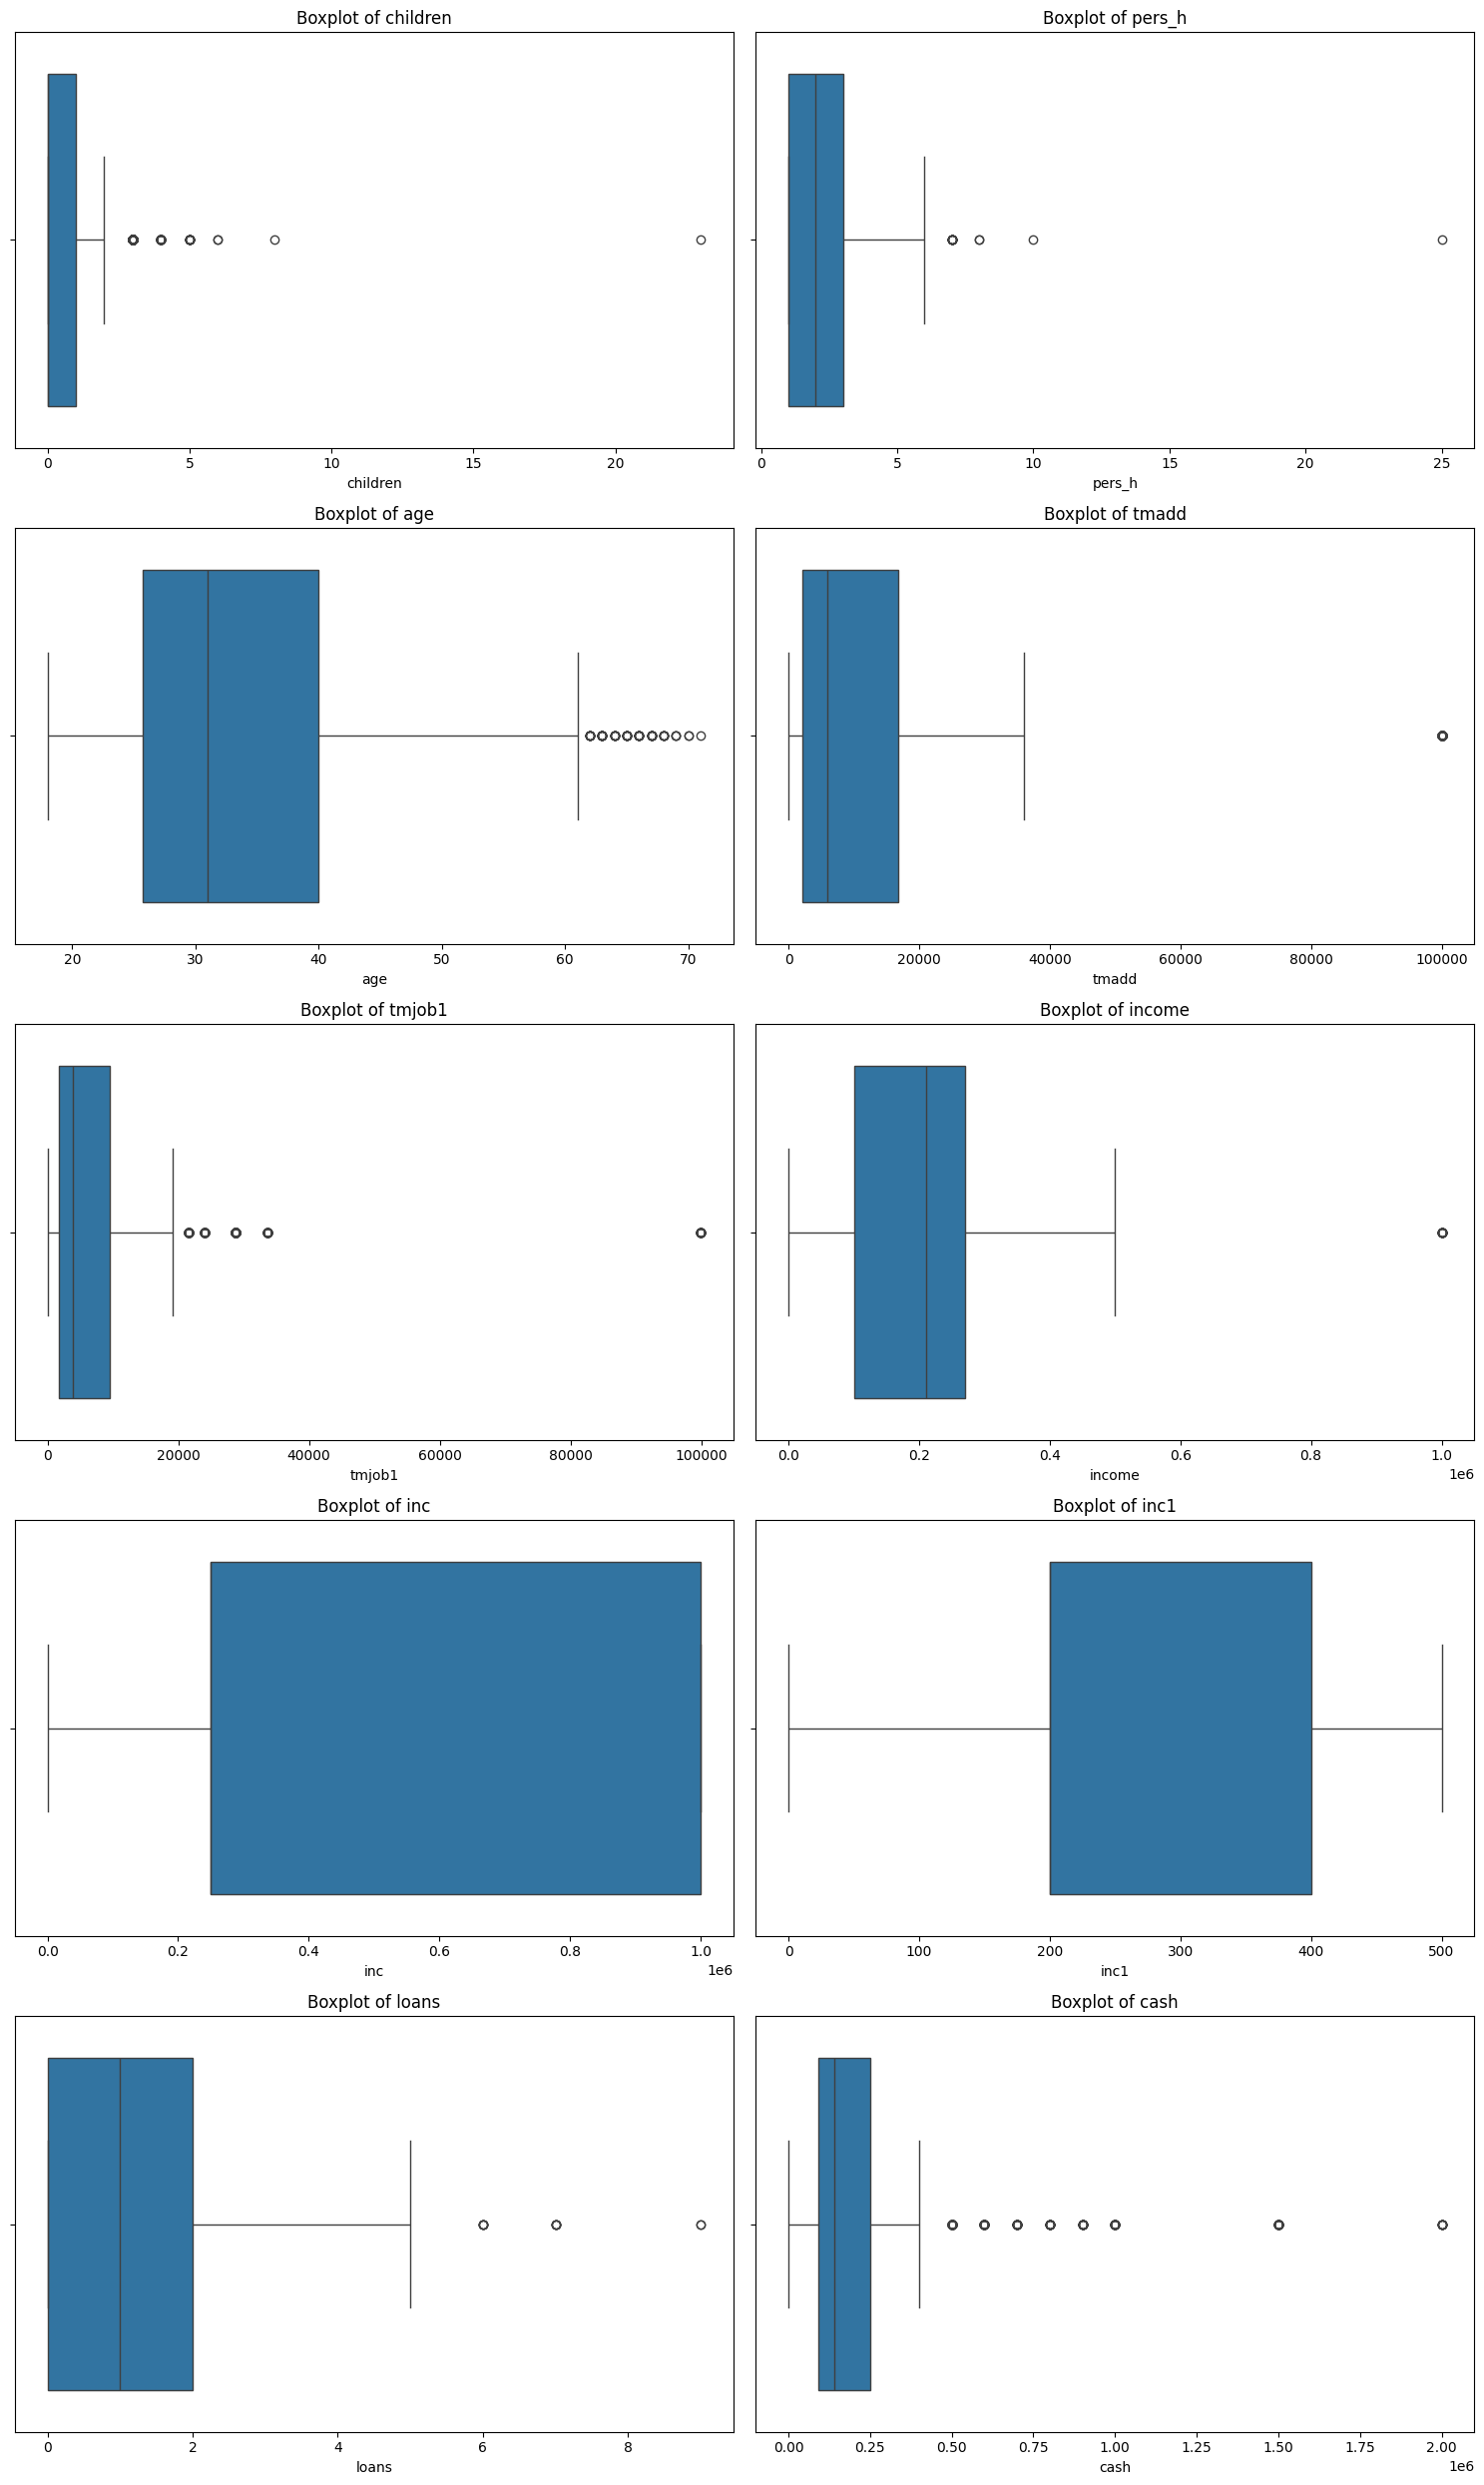

In [25]:
create_boxplots(df, numerical)

Efectivamente, podemos observar que las variables children, pers_h, age, tmadd, tmjob1, income, loans y cash contienes valores outliers.

#### Distribución de las variables

Ahora, plotearemos los histogramas para explorar si las variables con outliers siguen una distribucion normal o no.
Si las variables siguen una distribución normal, se realizará `Análisis del valor extremo`, sino, se buscara el `IQR (Rango intercuartil)`

In [26]:
outliers = ['children', 'pers_h', 'age', 'tmadd', 'tmjob1', 'income', 'loans', 'cash']

def create_hists(df, outliers):  
    num_plots = len(outliers)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    axes = axes.flatten()

    for i, column in enumerate(outliers):
        sns.histplot(x=df[column], ax=axes[i])
        axes[i].set_title(f'Boxplot of {column}')
        axes[i].set_xlabel(column)
    
    # Hide any extra subplots
    for j in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


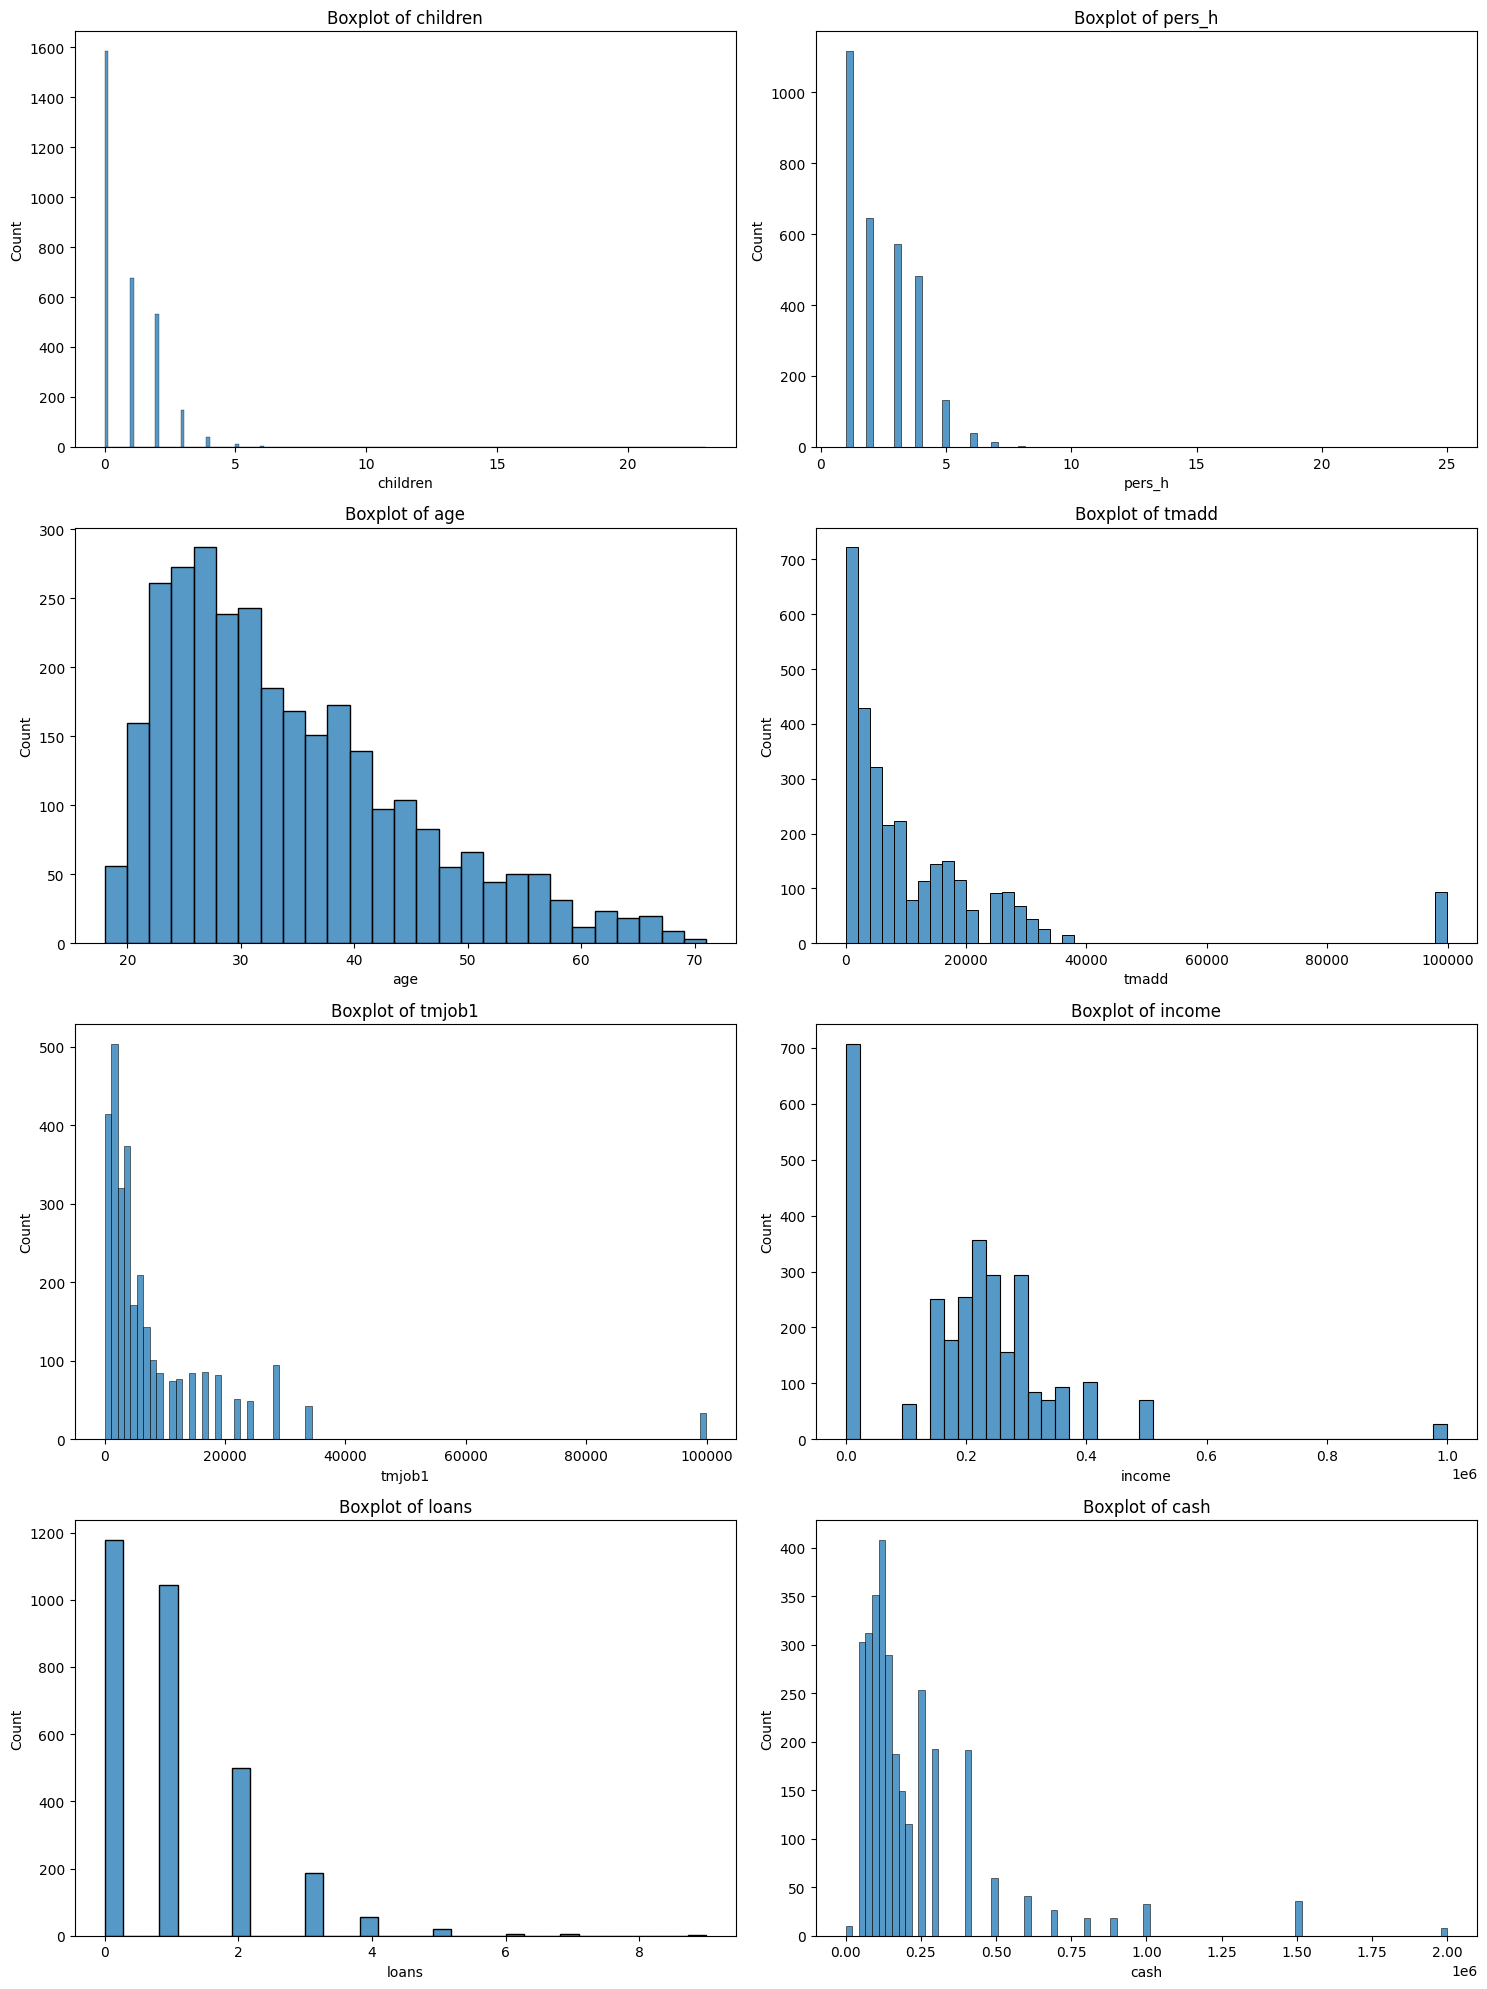

In [27]:
create_hists(df, outliers)

Es evidente a simple vista que las variables no siguen una distribución normal. Se considera que no es necesario realizar la prueba de Shapiro-Wilk para la comprobación de la normalidad.

Se opta por utilizar el rango intercuartil para encontrar outliers.

In [28]:
def find_outliers_IQR(df, column):
    IQR = df[column].quantile(0.75)-df[column].quantile(0.25)
    lower_fence = df[column].quantile(0.25) - (IQR * 3)
    upper_fence = df[column].quantile(0.75) + (IQR * 3)
    return (lower_fence, upper_fence)

In [29]:
for c in outliers:
    lower_fence, upper_fence = find_outliers_IQR(df, c)
    if df[c].min() < lower_fence:
        print(f'Los valores outliers de la variable {c} son < {lower_fence} o > {upper_fence}')
    else:
        print(f'Los valores outliers de la variable {c} son > {upper_fence}')


Los valores outliers de la variable children son > 4.0
Los valores outliers de la variable pers_h son > 9.0
Los valores outliers de la variable age son > 82.75
Los valores outliers de la variable tmadd son > 60900.0
Los valores outliers de la variable tmjob1 son > 33000.0
Los valores outliers de la variable income son > 780000.0
Los valores outliers de la variable loans son > 8.0
Los valores outliers de la variable cash son > 730000.0


### Declarar feature  vector  y variable objetivo

In [30]:
X = df.drop(['gb'], axis = 1)
y = df['gb']

## ⚒️ Feature Engineering y pre-processing

**Feature Engineering** es el proceso de transformar la data en características útiles que pueden servir para mejorar los modelos y aumentar sus predicciones.
A continuación se aplicará este concepto sobre diferentes tipos de variables.

Primero, mostraré nuevamente las variables categóricas y numéricas por separado.

In [31]:
X.dtypes

title       object
children     int64
pers_h       int64
age          int64
tmadd        int64
tmjob1       int64
tel         object
nmbloan     object
finloan     object
income       int64
ec_card     object
inc          int64
inc1         int64
status      object
bureau      object
location    object
loans        int64
regn        object
div         object
cash         int64
product     object
resid       object
nat         object
prof        object
car         object
cards       object
dtype: object

In [32]:
# Mostrar variables categóricas
categorical = [col for col in X.columns if X[col].dtypes == 'O']

categorical

['title',
 'tel',
 'nmbloan',
 'finloan',
 'ec_card',
 'status',
 'bureau',
 'location',
 'regn',
 'div',
 'product',
 'resid',
 'nat',
 'prof',
 'car',
 'cards']

In [33]:
# Mostrar variables numéricas
numerical = [col for col in X.columns if X[col].dtypes != 'O']

numerical

['children',
 'pers_h',
 'age',
 'tmadd',
 'tmjob1',
 'income',
 'inc',
 'inc1',
 'loans',
 'cash']

### Imputación de valores nulos

Debido a que en las variables numéricas no existen valores nulos, solo se imputan los valores nulos de las variables categóricas.

In [34]:
# Porcentaje de valores nulos en las variables categóricas en el set de entrenamiento
X[categorical].isnull().mean()

title       0.000000
tel         0.000000
nmbloan     0.000000
finloan     0.000000
ec_card     0.000000
status      0.000000
bureau      0.000000
location    0.000000
regn        0.000000
div         0.000000
product     0.004000
resid       0.178333
nat         0.000000
prof        0.000333
car         0.000000
cards       0.000000
dtype: float64

Puesto que estas variables son categóricas, se opta por imputar los valores nulos con la moda:

In [35]:
# Imputar los valores faltantes con la moda
for df2 in [X]:
    df2['product'].fillna(df['product'].mode()[0], inplace=True)
    df2['resid'].fillna(df['resid'].mode()[0], inplace=True)
    df2['prof'].fillna(df['prof'].mode()[0], inplace=True)

In [36]:
# Revisar valores faltantes en las variables categóricas de X_train 
X[categorical].isnull().sum()

title       0
tel         0
nmbloan     0
finloan     0
ec_card     0
status      0
bureau      0
location    0
regn        0
div         0
product     0
resid       0
nat         0
prof        0
car         0
cards       0
dtype: int64

In [37]:
# check missing values in categorical variables in X_train
X[categorical].isnull().sum()

title       0
tel         0
nmbloan     0
finloan     0
ec_card     0
status      0
bureau      0
location    0
regn        0
div         0
product     0
resid       0
nat         0
prof        0
car         0
cards       0
dtype: int64

Podemos observar, entonces, que no hay valores faltantes en X_train ni en X_test

### Outliers en las variables numéricas

Hemos podido observar que las siguientes variables contienen outliers:

In [38]:
pprint.pprint(outliers)

['children', 'pers_h', 'age', 'tmadd', 'tmjob1', 'income', 'loans', 'cash']


Usaré un enfoque de top-coding para limitar los valores máximos y eliminar los valores atípicos de las variables anteriores.

In [39]:
def max_value(df3, variable, top):
    return np.where(df3[variable]>top, top, df3[variable])


for df3 in [X]:
    for c in outliers:
        lower_fence, upper_fence = find_outliers_IQR(df, c)
        df3[c] = max_value(df3, c, upper_fence)

In [40]:
for c in outliers:
    print(f'{c}: ({X[c].max()})')

children: (4.0)
pers_h: (9.0)
age: (71.0)
tmadd: (60900.0)
tmjob1: (33000.0)
income: (780000.0)
loans: (8.0)
cash: (730000.0)


In [41]:
X[numerical].describe()

,children,pers_h,age,tmadd,tmjob1,income,inc,inc1,loans,cash
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.806333,2.353000,34.047667,10719.200000,7176.300000,194700.000000,415583.333333,238.566667,1.007333,199676.666667
std,1.020379,1.358801,10.951501,12539.489794,8041.363244,138504.528812,394636.844625,121.136990,1.108011,163088.712357
min,0.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,25.750000,2100.000000,1800.000000,100000.000000,250000.000000,200.000000,0.000000,90000.000000
50%,0.000000,2.000000,31.000000,6000.000000,3900.000000,210000.000000,250000.000000,200.000000,1.000000,140000.000000
75%,1.000000,3.000000,40.000000,16800.000000,9600.000000,270000.000000,1000000.000000,400.000000,2.000000,250000.000000
max,4.000000,9.000000,71.000000,60900.000000,33000.000000,780000.000000,1000000.000000,500.000000,8.000000,730000.000000


Ahora podemos ver que los valores atípicos están limitados.

### Balanceo de las variables categóricas

El desequilibrio de clases ocurre cuando hay una gran diferencia en el número de muestras entre las clases en un conjunto de datos. Esto puede sesgar el modelo. Por lo tanto, es importante identificar variables donde una clase supera el 90% de las muestras totales. 

In [42]:
for var in categorical: 
    frequency = X[var].value_counts() / len(X)
    if (frequency>0.9).any():
        pprint.pprint(X[var].value_counts()/float(len(X)))
        print('-------------')

location
100    0.998333
0      0.001667
Name: count, dtype: float64
-------------
resid
Lease    0.958333
Owner    0.041667
Name: count, dtype: float64
-------------


Para garantizar que el dataset no contiene variables desbalanceadas (la frecuencia de los registros no supera el 90%), se opta por eliminar características altamente desequilibradas. En particular, estas son location y resid

In [43]:
for var in categorical:
    frequency = X[var].value_counts() / len(X)
    if (frequency >= 0.9).any():
        X.drop(var, axis=1, inplace=True)

In [44]:
categorical = [var for var in X.columns if X[var].dtype=='O']
pprint.pprint(categorical)

['title',
 'tel',
 'nmbloan',
 'finloan',
 'ec_card',
 'status',
 'bureau',
 'regn',
 'div',
 'product',
 'nat',
 'prof',
 'car',
 'cards']


### Codificar variables categóricas

In [45]:
categorical

['title',
 'tel',
 'nmbloan',
 'finloan',
 'ec_card',
 'status',
 'bureau',
 'regn',
 'div',
 'product',
 'nat',
 'prof',
 'car',
 'cards']

In [46]:
X[categorical].head()

,title,tel,nmbloan,finloan,ec_card,status,bureau,regn,div,product,nat,prof,car,cards
0,R,200,0,0,100,V,300,0,0,"Radio, TV, Hifi",German,Others,Car,Cheque card
1,R,100,0,0,0,W,100,0,0,"Furniture,Carpet",German,Others,Without Vehicle,no credit cards
2,H,200,200,100,100,V,100,0,0,"Furniture,Carpet",German,"Civil Service, M",Car,Cheque card
3,R,200,0,0,0,V,300,0,0,"Furniture,Carpet",German,Others,Car,no credit cards
4,R,200,0,0,100,U,300,0,0,"Furniture,Carpet",German,"Civil Service, M",Without Vehicle,Cheque card


In [47]:
# Codificamos las variables binarias
encoder = ce.BinaryEncoder(cols=['ec_card', 'div', 'finloan'])

In [48]:
X = encoder.fit_transform(df)

In [49]:
X.head()

,title,children,pers_h,age,tmadd,tmjob1,tel,nmbloan,finloan_0,finloan_1,...,div_0,div_1,cash,product,resid,nat,prof,car,cards,gb
0,R,0,2,46,1500,3300,200,0,0,1,...,0,1,200000,"Radio, TV, Hifi",Lease,German,Others,Car,Cheque card,0
1,R,0,1,39,19200,600,100,0,0,1,...,0,1,250000,"Furniture,Carpet",Lease,German,Others,Without Vehicle,no credit cards,1
2,H,3,5,32,4800,10800,200,200,1,0,...,0,1,250000,"Furniture,Carpet",Lease,German,"Civil Service, M",Car,Cheque card,0
3,R,0,2,42,14400,3000,200,0,0,1,...,0,1,900000,"Furniture,Carpet",Lease,German,Others,Car,no credit cards,0
4,R,0,1,20,24000,900,200,0,0,1,...,0,1,400000,"Furniture,Carpet",Lease,German,"Civil Service, M",Without Vehicle,Cheque card,0


Podemos observar que se crearon dos variables adicionales para cada columna binarias (finloan, div, ec_card). 

Creamos, finalmente, el dataset codificado.

In [50]:
X = pd.concat([X[numerical], X[['finloan_0', 'finloan_1', 'div_0', 'div_1', 'ec_card_0', 'ec_card_1']], 
                    pd.get_dummies(X['title'], dtype=int),
                    pd.get_dummies(X['tel'], dtype=int),
                    pd.get_dummies(X['nmbloan'], dtype=int),
                    pd.get_dummies(X['status'], dtype=int),
                    pd.get_dummies(X['bureau'], dtype=int),
                    pd.get_dummies(X['regn'], dtype=int),
                    pd.get_dummies(X['product'], dtype=int),
                    pd.get_dummies(X['nat'], dtype=int),
                    pd.get_dummies(X['prof'], dtype=int),
                    pd.get_dummies(X['car'], dtype=int),
                    pd.get_dummies(X['cards'], dtype=int)], axis=1)

### Dividir la data en set de entrenamiento y test

In [51]:
random_seed = 42
np.random.seed(random_seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_seed)

In [52]:
X_train.shape, X_test.shape

((2400, 75), (600, 75))

In [55]:
X_train.head(10)

,children,pers_h,age,tmadd,tmjob1,income,inc,inc1,loans,cash,...,Car,Car and Motor bi,Without Vehicle,American Express,Cheque card,Mastercard/Euroc,Other credit car,VISA Others,VISA mybank,no credit cards
642,1,2,35,31200,5400,280000,1000000,400,1,250000,...,1,0,0,0,0,0,0,0,0,1
700,0,2,23,3000,600,250000,250000,200,1,120000,...,1,0,0,0,0,0,0,0,0,1
226,0,1,25,21600,1200,230000,250000,200,0,400000,...,1,0,0,0,0,0,0,0,0,1
1697,0,1,66,6600,8400,230000,250000,200,3,90000,...,0,0,1,0,0,0,0,0,0,1
1010,0,1,27,1200,1200,200000,250000,200,0,70000,...,0,0,1,0,0,0,0,0,0,1
1572,2,4,35,1200,2400,200000,250000,200,0,100000,...,1,0,0,0,0,0,0,0,0,1
776,2,4,42,9600,19200,1000000,1000000,500,3,250000,...,1,0,0,0,1,0,0,0,0,0
1730,0,2,27,3600,6000,250000,250000,200,1,100000,...,0,0,1,0,0,0,0,0,0,1
853,0,2,29,1500,8400,270000,1000000,400,2,110000,...,1,0,0,0,0,0,0,0,0,1
255,0,1,20,14400,300,400000,1000000,400,0,120000,...,1,0,0,0,0,0,0,0,0,1


In [56]:
X_test.head(10)

,children,pers_h,age,tmadd,tmjob1,income,inc,inc1,loans,cash,...,Car,Car and Motor bi,Without Vehicle,American Express,Cheque card,Mastercard/Euroc,Other credit car,VISA Others,VISA mybank,no credit cards
1801,0,1,22,26400,1200,220000,250000,200,2,170000,...,1,0,0,0,0,0,0,0,0,1
1190,0,1,25,1200,4500,150000,250000,200,1,150000,...,1,0,0,0,0,0,0,0,0,1
1817,0,1,31,99900,19200,340000,1000000,400,0,160000,...,1,0,0,0,0,0,0,0,0,1
251,2,4,30,9600,3000,0,0,100,1,150000,...,1,0,0,0,1,0,0,0,0,0
532,0,2,30,2400,900,0,0,0,2,400000,...,1,0,0,0,0,1,0,0,0,0
1117,0,2,33,99900,12000,300000,1000000,400,1,80000,...,1,0,0,0,0,0,0,0,0,1
1411,0,1,35,99900,1500,150000,250000,200,1,60000,...,0,0,1,0,0,0,0,0,0,1
140,0,1,28,6600,900,0,0,100,1,140000,...,1,0,0,0,1,0,0,0,0,0
408,0,1,20,14400,600,170000,250000,200,0,90000,...,1,0,0,0,0,0,0,0,0,1
606,1,3,26,8400,9600,150000,250000,300,0,130000,...,1,0,0,0,1,0,0,0,0,0


Ahora ya tenemos un conjunto de entranamiento y pruebas listo para la construcción de modelos. Antes de eso, debemos mapear todas las variables de características en la misma escala. 

### Feature Scaling

In [57]:
X_train.describe()

,children,pers_h,age,tmadd,tmjob1,income,inc,inc1,loans,cash,...,Car,Car and Motor bi,Without Vehicle,American Express,Cheque card,Mastercard/Euroc,Other credit car,VISA Others,VISA mybank,no credit cards
count,2400.000000,2400.000000,2400.000000,2400.00000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2.400000e+03,...,2400.00000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.844167,2.381667,34.026250,11852.25000,7958.375000,196241.666667,413958.333333,238.000000,1.030833,2.145583e+05,...,0.77000,0.005417,0.224583,0.000833,0.257083,0.022917,0.002500,0.000833,0.000833,0.715000
std,1.160651,1.452656,10.957863,17720.82362,12275.870449,145799.458898,393706.955849,121.156027,1.135600,2.411370e+05,...,0.42092,0.073414,0.417395,0.028861,0.437117,0.149669,0.049948,0.028861,0.028861,0.451509
min,0.000000,1.000000,18.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,25.000000,2100.00000,1800.000000,100000.000000,250000.000000,200.000000,0.000000,9.000000e+04,...,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,31.000000,6000.00000,3900.000000,210000.000000,250000.000000,200.000000,1.000000,1.400000e+05,...,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,3.000000,40.000000,16800.00000,9600.000000,270000.000000,1000000.000000,400.000000,2.000000,2.500000e+05,...,1.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,23.000000,25.000000,70.000000,99900.00000,99900.000000,1000000.000000,1000000.000000,500.000000,9.000000,2.000000e+06,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
# Convertir todos los nombres de columna a cadenas
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [62]:
cols = X_train.columns

In [63]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [64]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [65]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [66]:
X_train.describe()

,children,pers_h,age,tmadd,tmjob1,income,inc,inc1,loans,cash,...,Car,Car and Motor bi,Without Vehicle,American Express,Cheque card,Mastercard/Euroc,Other credit car,VISA Others,VISA mybank,no credit cards
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.00000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.036703,0.057569,0.308197,0.118641,0.079663,0.196242,0.413958,0.476000,0.114537,0.107279,...,0.77000,0.005417,0.224583,0.000833,0.257083,0.022917,0.002500,0.000833,0.000833,0.715000
std,0.050463,0.060527,0.210728,0.177386,0.122882,0.145799,0.393707,0.242312,0.126178,0.120568,...,0.42092,0.073414,0.417395,0.028861,0.437117,0.149669,0.049948,0.028861,0.028861,0.451509
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.134615,0.021021,0.018018,0.100000,0.250000,0.400000,0.000000,0.045000,...,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.041667,0.250000,0.060060,0.039039,0.210000,0.250000,0.400000,0.111111,0.070000,...,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.086957,0.083333,0.423077,0.168168,0.096096,0.270000,1.000000,0.800000,0.222222,0.125000,...,1.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Ahora tenemos el conjunto de datos `X_train` listo para ingresar al clasificador de regresión logística.

# 🚂 Entrenamiento del modelo 

In [69]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [70]:
# iInstanciamos el modelo
logreg = LogisticRegression(solver='liblinear', random_state=0)

# Ajustamos el modelo
logreg.fit(X_train, y_train)


LogisticRegression(random_state=0, solver='liblinear')

# 🔮 Predicción de resultados 

In [71]:
y_pred_test = logreg.predict(X_test)
y_pred_test

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,

## Método predict-proba

El método **predict_proba** proporciona las probabilidades de la variable objetivo (0 y 1) en este caso, en forma de matriz.

`0 es para la probabilidad de que no pague` y `1 es para la probabilidad de que pague`.

In [72]:
# Probabilidad de que la salida sea 0 - No paga
logreg.predict_proba(X_test)[:,0]

array([0.1367491 , 0.26548427, 0.55470211, 0.70511394, 0.58140709,
       0.56587559, 0.16195382, 0.29773501, 0.29919957, 0.77589682,
       0.31450107, 0.68574545, 0.37218766, 0.70295021, 0.60714367,
       0.42180894, 0.1109122 , 0.24388811, 0.10351038, 0.58182783,
       0.29995281, 0.72561195, 0.45074581, 0.59647953, 0.63280629,
       0.82782908, 0.31279824, 0.48668295, 0.57904807, 0.5508509 ,
       0.64676399, 0.19709825, 0.40280133, 0.74083982, 0.52140727,
       0.43853875, 0.24405203, 0.86156112, 0.30730273, 0.38424155,
       0.24103153, 0.43326075, 0.48506519, 0.75498392, 0.21725508,
       0.67100977, 0.55204465, 0.37684657, 0.28548142, 0.15936715,
       0.49138967, 0.46115198, 0.37254713, 0.08832746, 0.35062803,
       0.55026573, 0.4632776 , 0.43007763, 0.7145413 , 0.63246186,
       0.17888616, 0.42390853, 0.61628796, 0.38897423, 0.22611103,
       0.52744737, 0.32277329, 0.6441012 , 0.68176242, 0.36945948,
       0.60807304, 0.66477084, 0.64285149, 0.73095592, 0.64202

In [73]:
# Probabiliad de que la salida sea 1 - Paga
logreg.predict_proba(X_test)[:,1]

array([0.8632509 , 0.73451573, 0.44529789, 0.29488606, 0.41859291,
       0.43412441, 0.83804618, 0.70226499, 0.70080043, 0.22410318,
       0.68549893, 0.31425455, 0.62781234, 0.29704979, 0.39285633,
       0.57819106, 0.8890878 , 0.75611189, 0.89648962, 0.41817217,
       0.70004719, 0.27438805, 0.54925419, 0.40352047, 0.36719371,
       0.17217092, 0.68720176, 0.51331705, 0.42095193, 0.4491491 ,
       0.35323601, 0.80290175, 0.59719867, 0.25916018, 0.47859273,
       0.56146125, 0.75594797, 0.13843888, 0.69269727, 0.61575845,
       0.75896847, 0.56673925, 0.51493481, 0.24501608, 0.78274492,
       0.32899023, 0.44795535, 0.62315343, 0.71451858, 0.84063285,
       0.50861033, 0.53884802, 0.62745287, 0.91167254, 0.64937197,
       0.44973427, 0.5367224 , 0.56992237, 0.2854587 , 0.36753814,
       0.82111384, 0.57609147, 0.38371204, 0.61102577, 0.77388897,
       0.47255263, 0.67722671, 0.3558988 , 0.31823758, 0.63054052,
       0.39192696, 0.33522916, 0.35714851, 0.26904408, 0.35797

# 🎯 Precisión del modelo

In [76]:
print('Puntaje de precisión del modelo: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Puntaje de precisión del modelo: 0.6767


Aquí, **y_test** son las etiquetas de clase verdaderas y **y_pred_test** son las etiquetas de clase previstas en el conjunto de pruebas.

### Comparación de la precisión de train y test

In [77]:
y_pred_train = logreg.predict(X_train)
y_pred_train

array([1, 1, 1, ..., 1, 1, 1])

In [79]:
print('Precisión del modelo con el set de entrenamiento: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Precisión del modelo con el set de entrenamiento: 0.6971


### Revisar overfitting y underfitting

In [81]:
# print the scores on training and test set

print('Puntaje set de train: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Puntaje set de test: {:.4f}'.format(logreg.score(X_test, y_test)))

Puntaje set de train: 0.6971
Puntaje set de test: 0.6767


La puntuación de precisión del conjunto de entrenamiento es 0.6971, mientras que la precisión del conjunto de prueba es 0.6767. Estos dos valores son bastante comparables. Por tanto, no se trata de un sobreajuste.

En regresión logística, utilizamos el valor predeterminado de C = 1. Proporciona un buen rendimiento con aproximadamente un 70 % de precisión tanto en el conjunto de entrenamiento como en el de prueba. Pero el rendimiento del modelo tanto en el conjunto de entrenamiento como en el de prueba es muy comparable. Probablemente se trate de un caso de underfitting.

Aumentaré C y me adaptaré a un modelo más flexible.

In [82]:
logreg100 = LogisticRegression(C=100, solver='liblinear', random_state=0)
logreg100.fit(X_train, y_train)

LogisticRegression(C=100, random_state=0, solver='liblinear')

In [84]:
print('Training set score: {:.4f}'.format(logreg100.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(logreg100.score(X_test, y_test)))

Training set score: 0.6958
Test set score: 0.6700


Podemos ver que C =100 resulta en un modelo con una precisión menor. Esto sugiere que el modelo podría estar sobreajustándose a los datos de entrenamiento con el valor más alto de C.

En regresión logística, el parámetro C es el inverso de la fuerza de regularización. Los valores más pequeños de C especifican una regularización más fuerte, lo que puede ayudar a prevenir el sobreajuste al penalizar los valores de coeficientes grandes. Por el contrario, valores más altos de C dan como resultado una regularización más débil, lo que permite que el modelo se ajuste más estrechamente a los datos de entrenamiento, lo que podría provocar un sobreajuste.

Por esto, podríamos pensar que un C menor podría tener una precisión mejor. Probemos:

In [93]:
logreg001 = LogisticRegression(C=0.01, solver='liblinear', random_state=0)
logreg001.fit(X_train, y_train)


LogisticRegression(C=0.01, random_state=0, solver='liblinear')

In [94]:
print('Training set score: {:.4f}'.format(logreg001.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(logreg001.score(X_test, y_test)))

Training set score: 0.6629
Test set score: 0.6667
